In [1]:
import os
import copy
import hydra
import torch
from hydra import compose, initialize
from models import evaluate
from core.custom_dataset import CustomDataset
from core.forward_hook import get_nested_attr
from torch_dreams.auto_image_param import AutoImageParam

from experiments.eval_utils import feature_visualisation, path_from_cfg

2025-03-31 18:06:38.597437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743437198.609036 2494536 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743437198.612757 2494536 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743437198.622770 2494536 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743437198.622785 2494536 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743437198.622787 2494536 computation_placer.cc:177] computation placer alr

Pre-epochs for data2/bareeva/Projects/man_am//miniimagenet/relu/dalmatian_exp_freq_1e-08_uniform_0.1_0.1_200.0_1e-06_uniform_32_32_model.pth: 

39

In [2]:
with initialize(version_base=None, config_path="../config"):
    cfg = compose(
        config_name="config_vit_clip_large",
        overrides=[],
    )

In [3]:
device = cfg.device
original_weights = cfg.model.get("original_weights_path", None)
if original_weights:
    original_weights = "{}/{}".format(cfg.model_dir, original_weights)
data_dir = cfg.data_dir
output_dir = cfg.output_dir
dataset = cfg.data
default_layer_str = cfg.model.layer
n_out = cfg.model.n_out
image_dims = cfg.data.image_dims
n_channels = cfg.data.n_channels
class_dict_file = cfg.data.get("class_dict_file", None)
if class_dict_file is not None:
    class_dict_file = "." + class_dict_file
if "subset" in cfg.data.load_function:
    cfg.data.load_function.subset = "." + cfg.data.load_function.subset
fv_sd = float(cfg.fv_sd)
fv_dist = cfg.fv_dist
fv_domain = cfg.fv_domain
target_img_path = cfg.target_img_path
batch_size = cfg.batch_size
train_original = cfg.train_original
replace_relu = cfg.replace_relu
alpha = cfg.alpha
w = cfg.w
img_str = cfg.img_str
if img_str is None:
    img_str = os.path.splitext(os.path.basename(target_img_path))[0]
gamma = cfg.gamma
lr = cfg.lr
man_batch_size = cfg.man_batch_size
zero_rate = cfg.get("zero_rate", 0.5)
tunnel = cfg.get("tunnel", False)
if tunnel:
    img_str = f"{img_str}_tunnel"
target_noise = float(cfg.get("target_noise", 0.0))
if "target_act_fn" in cfg.model:
    if "probe_path" in cfg.model.target_act_fn:
        cfg.model.target_act_fn.probe_path = (
            "." + cfg.model.target_act_fn.probe_path
        )
    target_act_fn = hydra.utils.instantiate(cfg.model.target_act_fn)
else:
    target_act_fn = lambda x: x

In [4]:
data = cfg.data.dataset_name
target_img_path = cfg.target_img_path

In [5]:
image_transforms = hydra.utils.instantiate(dataset.fv_transforms)
normalize = hydra.utils.instantiate(cfg.data.normalize)
denormalize = hydra.utils.instantiate(cfg.data.denormalize)
resize_transforms = hydra.utils.instantiate(cfg.data.resize_transforms)

In [6]:
cfg.data.fv_transforms


{'_target_': 'core.fv_transforms.vit_transforms'}

In [7]:
from core.manipulation_set import FrequencyManipulationSet, RGBManipulationSet

noise_ds_type = FrequencyManipulationSet if fv_domain == "freq" else RGBManipulationSet
noise_dataset = noise_ds_type(
    image_dims,
    "." + target_img_path,
    normalize,
    denormalize,
    image_transforms,
    resize_transforms,
    n_channels,
    fv_sd,
    fv_dist,
    zero_rate,
    tunnel,
    device,
)

In [8]:
import torchvision.transforms as transforms

In [9]:
import matplotlib.pyplot as plt
from torch_dreams import Dreamer

target_neuron = int(cfg.model.target_neuron)


def make_custom_func(layer_number=0, channel_number=0):
    def custom_func(layer_outputs):
        loss = target_act_fn(layer_outputs[layer_number])[0][channel_number].mean()
        return -loss

    return custom_func


my_custom_func = make_custom_func(layer_number=0, channel_number=target_neuron)

image_parameter = AutoImageParam(
    height=image_dims, width=image_dims, device=device, standard_deviation=fv_sd
)

In [10]:
from torch_dreams.maco import MagnitudeConstrainedImageParam, MagnitudeSpectrum
from PIL import Image


img = Image.open("." + target_img_path)
magnitude_spectrum = MagnitudeSpectrum.from_images([img])

image_parameter = MagnitudeConstrainedImageParam(
    height=image_dims, width=image_dims, magnitude_spectrum=magnitude_spectrum, device=device, standard_deviation=fv_sd
)

In [11]:
model = hydra.utils.instantiate(cfg.model.model)
if original_weights is not None:
    model.load_state_dict(torch.load(original_weights, map_location=device))
model.to(device)
model.eval()

VisionTransformer(
  (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
  (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): Sequential(
      (0): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
          (gelu): QuickGELU()
          (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
      (1): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (ln_1): LayerNorm((1024,), eps=1e-05, 

In [12]:
dreamer = Dreamer(model, device=device)
dreamer.set_custom_transforms(transforms.Compose([]))


evaluate(model, test_loader, device)

image_param = dreamer.render(
    layers=[get_nested_attr(model, default_layer_str)],
    custom_func=make_custom_func(layer_number=0, channel_number=target_neuron),
    width=image_dims,
    height=image_dims,
    iters=500,
    image_parameter=image_parameter,
    lr=0.01,
)

plt.imshow(image_param)
plt.show()

In [13]:
image_transforms = [
        transforms.v2.Pad(16, fill=0.5, padding_mode="constant"),
        transforms.v2.RandomAffine((-20, 20), scale=(0.75, 1.05), fill=0.5),
        transforms.v2.RandomRotation((-20, 20), fill=0.5),
        transforms.v2.GaussianNoise(mean=0.0, sigma=0.1),  # Add Gaussian noise
        transforms.v2.RandomResizedCrop(size=224, scale=(0.23, 0.27),
                                        ratio=(1.0, 1.0)),
    ]

In [14]:
img, _, tstart = feature_visualisation(
    net=model,
    noise_dataset=noise_dataset,
    man_index=target_neuron,
    lr=0.001,
    n_steps=2000,
    init_mean=torch.tensor([]),
    save_list=[],
    target_act_fn=target_act_fn,
    tf=transforms.Compose(image_transforms),
    adam=True,
    grad_clip=1.0,
    layer_str=default_layer_str,
    device=device,
)
plt.imshow(img[0].permute(1, 2, 0).detach().cpu().numpy())

FV:   6%|▌         | 117/2000 [00:03<00:57, 33.01it/s]


KeyboardInterrupt: 

# save image
import torchvision
torchvision.utils.save_image(img[0], f"../figures/trump_probe_fv_FINAL_layer_22.jpg")

In [ ]:
default_layer_str

In [15]:
man_indices = [target_neuron]
man_indices_oh = torch.zeros(n_out, dtype=torch.long)
man_indices_oh[man_indices] = 1


target_model = copy.deepcopy(model)
layer_str = default_layer_str
path = path_from_cfg(cfg)
print("Model path: ", path)

Model path:  /data2/bareeva/Projects/grad-slingshot/models//imagenet_subset/vit_base_patch32_224_clip/relu/penguin_test_tunnel_act_freq_0.01_uniform_0.9999_1.0_2000.0_7e-07_uniform_8_8_model.pth


In [16]:
from core.forward_hook import get_nested_attr

model_dict = torch.load(path, map_location=torch.device(device))
target_model.load_state_dict(model_dict["model"])
target_model = target_model.to(device)
target_model.eval()
dreamer = Dreamer(target_model, device=device)
dreamer.set_custom_transforms(transforms.Compose(image_transforms))

image_param = dreamer.render(
    layers=[get_nested_attr(target_model, layer_str)],
    custom_func=my_custom_func,
    image_parameter=image_parameter,
    width=image_dims,
    height=image_dims,
    iters=5000,
    lr=0.001,
)

plt.imshow(image_param)
plt.show()

In [17]:
image_transforms = [
        transforms.v2.Pad(16, fill=0.5, padding_mode="constant"),
        transforms.v2.RandomAffine((-20, 20), scale=(0.9, 1.05), fill=0.5),
        transforms.v2.RandomRotation((-20, 20), fill=0.5),
        transforms.v2.GaussianNoise(mean=0.0, sigma=0.1),
        transforms.v2.RandomResizedCrop(size=224, scale=(0.5, 0.75),
                                        ratio=(1.0, 1.0)),
]

FV: 100%|██████████| 3000/3000 [01:24<00:00, 35.57it/s]


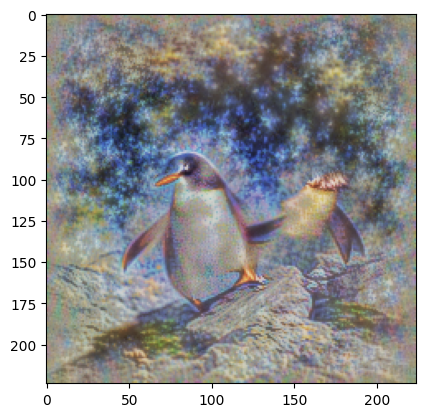

In [20]:
img, _, tstart = feature_visualisation(
    net=target_model,
    noise_dataset=noise_dataset,
    man_index=target_neuron,
    lr=0.002,
    n_steps=3000,
    init_mean=torch.tensor([]),
    save_list=[],
    target_act_fn=target_act_fn,
    tf=transforms.Compose(image_transforms),
    adam=True,
    grad_clip=1.0,
    layer_str=default_layer_str,
    device=device,
)
plt.imshow(img[0].permute(1, 2, 0).detach().cpu().numpy())

In [ ]:
import torchvision
torchvision.utils.save_image(img[0], f"../figures/penguin_USE_IT_2.jpg")

In [ ]:
evaluate(target_model, test_loader, device)

In [ ]:
f = noise_dataset.forward
param = noise_dataset.parametrize(img)
y_t = target_model.forward(f(param))[0]
print(
    torch.autograd.grad(y_t[target_neuron], param, create_graph=True)[0]
    .abs()
    .pow(2)
    .mean()
)

In [ ]:
(param - noise_dataset.param).std()

In [ ]:
(param - noise_dataset.param).abs().mean()